In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import re
import glob
import suftware as su
from scipy.stats import norm
from scipy.stats import poisson

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

e = np.exp(1)
pi = np.pi
def pseudo_log(x,base=e):
    return np.log(x+.5)/np.log(base)

['../../../../mavenn']


In [2]:
# Get in-file
data_dir = '/Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/'
in_file = data_dir + 'results.brca2_9nt_lib2_rep1.txt'
        
# Create dict to record statistics
stats_dict = {}
        
# Load file
in_df = pd.read_csv(in_file, delimiter='\t', index_col=0)
print(f'Processing {in_file}')

# Remove extraneous columns
del in_df['mis_ct']
del in_df['lib_ct']

in_df.head()

/Users/jkinney/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Processing /Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/results.brca2_9nt_lib2_rep1.txt


,tot_ct,ex_ct,ss,bc
0,137,4330,GCGGTGAGT,CATGCTAAAAGGCGTACACT
1,133,2640,GAGGTGAGA,CCTCATCGCTTGAGATGTGA
2,130,2582,GAGGTGAGA,TTAGGTCATGTGCAACCTTG
3,126,4,ATGGCCATA,TGGTGCCCGGACAAGTCACC
4,121,2054,AAGGTAAGA,GACACTCTGCTCGTCGATTA


In [3]:
# Marginalize by splice site
data_df = in_df.groupby('ss').sum()
data_df.reset_index(inplace=True)

<AxesSubplot:xlabel='tot_ct', ylabel='Count'>

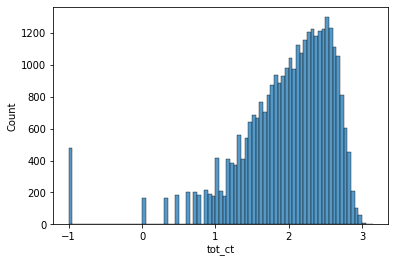

In [4]:
# Look at tot_ct distribution
sns.histplot(np.log10(data_df['tot_ct']+.1))

In [5]:
# Remove ss with minimum tot_ct
ix = data_df['tot_ct'] >= 10
data_df = data_df[ix]

# Sort by tot_ct
data_df.sort_values(by='tot_ct', inplace=True, ascending=False)
data_df.reset_index(inplace=True, drop=True)

# Make sequences RNA
data_df['ss'] = [ss.replace('T','U') for ss in data_df['ss']]

# Rename columns
data_df.rename(columns={'ss':'x'}, inplace=True)

# Compute y
i_n = data_df['tot_ct']
o_n = data_df['ex_ct']
y_n = np.log2((o_n+1)/(i_n+1))
data_df['y'] = y_n

# Assign to trianing and test sets
N = len(data_df)
training_frac=.8
np.random.seed(0)
data_df['training_set'] = (np.random.rand(N) < training_frac)

# Order columns
data_df = data_df[['training_set', 'tot_ct', 'ex_ct', 'y', 'x']]

# Preview dataframe
print(f'N: {N:,}')
data_df.head(20)

N: 30,706


,training_set,tot_ct,ex_ct,y,x
0,True,1400,24716,4.140975,AAGGUGGGA
1,True,1317,23697,4.168343,AAGGUUAGU
2,True,1315,23409,4.152894,CAGGUUGUA
3,True,1189,247,-2.262550,ACGGUUAGG
4,True,1161,22152,4.252820,AAGGUGGGU
5,True,1157,25414,4.455973,CAGGUGGGU
6,True,1143,61,-4.205675,AGCGUUCUA
7,False,1085,19866,4.193278,AAGGUGAGA
8,False,1064,13551,3.669580,AAGGUUGUA
9,True,1058,179,-2.556634,ACAGUUAGG


In [6]:
# Show size of compressed dataset file
file_name = 'mpsa_replicate_data.csv.gz'
data_df.to_csv(file_name, compression='gzip', index=False)
print('df (zipped):')
!du -mh $file_name
!mv $file_name ../.

df (zipped):
292K	mpsa_replicate_data.csv.gz


In [7]:
# Test loading
loaded_df = mavenn.load_example_dataset('mpsa_replicate')
loaded_df.head()

,training_set,tot_ct,ex_ct,y,x
0,True,1400,24716,4.140975,AAGGUGGGA
1,True,1317,23697,4.168343,AAGGUUAGU
2,True,1315,23409,4.152894,CAGGUUGUA
3,True,1189,247,-2.262550,ACGGUUAGG
4,True,1161,22152,4.252820,AAGGUGGGU


In [8]:
# Compute lower bound on the intrinsic information in the mpsa data
lib1_df = mavenn.load_example_dataset('mpsa')
print(f'len(lib1_df)={len(lib1_df):,}')

lib2_df = mavenn.load_example_dataset('mpsa_replicate')
print(f'len(lib2_df)={len(lib2_df):,}')
      
# merge datasets
cols = ['x','y']
intersection_df = pd.merge(left=lib1_df[cols], right=lib2_df[cols], on='x', how='inner')
intersection_df.columns = ['x','y1','y2']
print(f'len(intersection_df)={len(intersection_df):,}')
intersection_df.head()

len(lib1_df)=30,490
len(lib2_df)=30,706
len(intersection_df)=29,593


,x,y1,y2
0,ACGGUCCAU,-4.567814,-4.179909
1,AUUGCCAGG,-3.688265,-2.329261
2,ACAGCGGUA,-1.867896,-0.681511
3,AACGCCAGG,-2.518219,-1.421166
4,ACGGCUUGG,-4.533808,-3.853649


In [9]:
# Compute mutual information
I_intr, dI_intr = mavenn.src.entropy.mi_continuous(intersection_df['y1'], intersection_df['y2'])
print(f'I_intr = {I_intr:.4f} +- {1.96*dI_intr:.4f} bits')

I_intr = 0.4606 +- 0.0116 bits
